In [0]:
#from tensorflow import test
#test.gpu_device_name()

'/device:GPU:0'

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
#path = '/content/gdrive/My Drive/Colab Notebooks/ArXiv_Classifier'
path=""

In [2]:
import os
import pickle
import json
import pandas as pd
from itertools import cycle

import numpy as np
np.random.seed(123)

from tensorflow import set_random_seed
set_random_seed(123)

from keras.models import Sequential, save_model, load_model
from keras.layers import *
from keras import backend as K
from sklearn.metrics import f1_score

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
from seaborn import color_palette 
plt.style.use('seaborn')

Using TensorFlow backend.


# Summary

Seeing as the data that I wish to use for classification is medium-sized text in natural language, i.e. inherently a variable-length temporal sequence of tokens, the best candidate for a succesful net-architecture seem to be a **recurrent neural network**. I will fit my data to two such networks, both provided out-of-the-box by keras:
* the simple (i.e. fully connected) recurrent network, **SimpleRNN**,
* the long-short-term-memory, **LSTM**,

both **24-dimensional** and **one-directional** (default: from left to right with left-zero-padded input).

The recurrent net will sit between:
* a trainable embedding initialized with the weights pre-trained with global-averaging (see *keras_GlobalAvg_GridSearch.ipynb*)
* a dense layer with softmax.

Those neural-nets allow one to mask the *zeros* (***mask_zero=True***) which is done by default by our wrapper class, and it is used both here and previosly in *keras_GlobalAvg_GridSearch.ipynb*.

I will keep on using both loss functions considered earlier: the usual ***categorical crossentropy*** and the custom ***my_loss***. Aside from that we stick to *batch_size=200* and *optimizer=nadam*.

This means that the starting embedding layers eployed here were trained with those same loss-functions, batch_sizes, optimizers, and the same train-data, but on a simpler architecture. The rationale is the following: the simple architecture has managed to roughly group together words that belong to the same topic reaching 80% macro-F1 on validation data. Now the more complicated nets are given a chance to find some nuanced but generalizable patterns that would help to better classify the remaining 20%.

Also, small amount of *dropout regularization* is used here and there.

**A summary of the metrics is at the bottom.**

---
### Boilerplate

In [3]:
#! mkdir keras_RNN_LSTM_results
working_dir = 'keras_RNN_LSTM_results'

In [4]:
X_train = np.load(os.path.join(path, "data", "Kdata", "X_train.npy")) #[-n_sample:]
y_train = np.load(os.path.join(path, "data", "Kdata", "y_train.npy")) #[-n_sample:]
X_val = np.load(os.path.join(path, "data", "Kdata", "X_val.npy")) #[-n_sample:]
y_val = np.load(os.path.join(path, "data", "Kdata", "y_val.npy")) #[-n_sample:]

In [5]:
global_params = pickle.load(open(os.path.join(path, "global_params.p"), "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [6]:
%run keras_custom_functions.ipynb

# notebook1 = '/content/gdrive/My\ Drive/Colab\ Notebooks/ArXiv_Classifier/keras_custom_functions.ipynb'
# %run $notebook1

#my_metrics = list(CUSTOM_OBJECTS.values())
my_metrics = ['categorical_accuracy', macroPrec, macroF1, macroRecall]
my_metrics

['categorical_accuracy',
 <function __main__.macroPrec(y_true, y_pred)>,
 <function __main__.macroF1(y_true, y_pred)>,
 <function __main__.macroRecall(y_true, y_pred)>]

In [7]:
%run keras_plot_history.ipynb
%run keras_blackbox_wrapper.ipynb

# notebook2 = '/content/gdrive/My\ Drive/Colab\ Notebooks/ArXiv_Classifier/keras_plot_history.ipynb'
# %run $notebook2

# notebook3 = '/content/gdrive/My\ Drive/Colab\ Notebooks/ArXiv_Classifier/keras_blackbox_wrapper.ipynb'
# %run $notebook3

---

In [8]:
batch_size = 200
optimizer = 'nadam'
epochs = 5

In [9]:
embedd_file_crossent = os.path.join(path, 'keras_GlobalAvg_GridSearch_results', 'GlobalAvg_categorical_crossentropy_batch200_nadam_weights.p')
embedd_file_myloss = os.path.join(path, 'keras_GlobalAvg_GridSearch_results', 'GlobalAvg_my_loss_batch200_nadam_weights.p')

---
## Simple Recurrent Neural Net

In [10]:
layers_rnn = [SimpleRNN(24, dropout=0.1, recurrent_dropout=0.1)]

#### loss = categorical_crossentropy

In [12]:
# 1

loss='categorical_crossentropy'

model_rnn1 = BlackBox(tag="SRNN",\
                      layers=layers_rnn, loss=loss, batch_size=batch_size, optimizer=optimizer,\
                      epochs=epochs, metrics=my_metrics)

model_rnn1.load_embedd(embedd_file_crossent, trainable=True)
model_rnn1.summary()

loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24)                1800      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 150       
Total params: 13,867,150
Trainable params: 13,867,150
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_rnn1.fit(X_train, y_train, validate_on=(X_val, y_val))
model_rnn1.Ksave()
model_rnn1.save_hist()

loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/5
500000/500000 [==============================] - 2924s 6ms/step - loss: 0.4743 - categorical_accuracy: 0.8558 - macroPrec: 0.4269 - macroF1: 0.4135 - macroRecall: 0.4125 - val_loss: 0.3950 - val_categorical_accuracy: 0.8886 - val_macroPrec: 0.4794 - val_macroF1: 0.4588 - val_macroRecall: 0.4576
Epoch 2/5
500000/500000 [==============================] - 2926s 6ms/step - loss: 0.4398 - categorical_accuracy: 0.8615 - macroPrec: 0.4514 - macroF1: 0.4274 - macroRecall: 0.4184 - val_loss: 0.4556 - val_categorical_accuracy: 0.8609 - val_macroPrec: 0.4302 - val_macroF1: 0.4209 - val_macroRecall: 0.4189
Epoch 3/5
500000/500000 [==============================] - 2922s 6ms/step - loss: 0.4685 - categorical_accuracy: 0.8513 - macroPrec: 0.4440 - macroF1: 0.4139 - macroRecall: 0.4034 - val_loss: 0.4847 - val_categorical_ac

In [13]:
model_rnn1.load_hist()
model_rnn1.Kload()

Ovewriting the model.


loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True


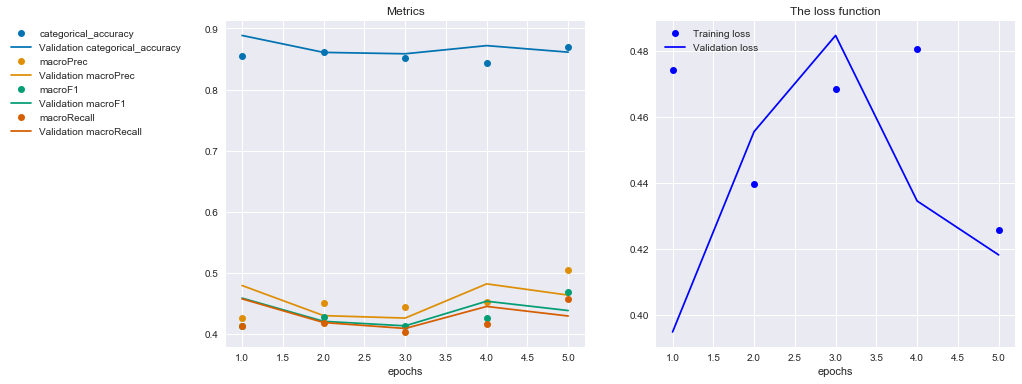

In [14]:
model_rnn1.plot(with_loss=True)

In [15]:
eval_rnn1 = model_rnn1.evaluate(X_val, y_val)

In [16]:
eval_rnn1

,SRNN
cat_cross,0.418292
my_loss,0.534548
cat_acc,0.861245
macroPrec,0.714560
macroF1,0.464040
macroRecall,0.437254


#### loss = *my_loss*

In [24]:
# 2

loss = my_loss

model_rnn2 = BlackBox(tag="SRNN",\
                      layers=layers_rnn, loss=loss, batch_size=batch_size, optimizer=optimizer,\
                      epochs=epochs, metrics=my_metrics)

model_rnn2.load_embedd(embedd_file_myloss, trainable=True)
model_rnn2.summary()

loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24)                1800      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 150       
Total params: 13,867,150
Trainable params: 13,867,150
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_rnn2.fit(X_train, y_train, validate_on=(X_val, y_val))
model_rnn2.Ksave()
model_rnn2.save_hist()

loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/5
500000/500000 [==============================] - 2979s 6ms/step - loss: 0.5207 - categorical_accuracy: 0.8173 - macroPrec: 0.5068 - macroF1: 0.4770 - macroRecall: 0.4796 - val_loss: 0.4577 - val_categorical_accuracy: 0.8623 - val_macroPrec: 0.5692 - val_macroF1: 0.5459 - val_macroRecall: 0.5511
Epoch 2/5
500000/500000 [==============================] - 2982s 6ms/step - loss: 0.4807 - categorical_accuracy: 0.8147 - macroPrec: 0.5514 - macroF1: 0.5229 - macroRecall: 0.5329 - val_loss: 0.4931 - val_categorical_accuracy: 0.7948 - val_macroPrec: 0.5343 - val_macroF1: 0.5100 - val_macroRecall: 0.5144
Epoch 3/5
500000/500000 [==============================] - 2944s 6ms/step - loss: 0.4537 - categorical_accuracy: 0.8213 - macroPrec: 0.5590 - macroF1: 0.5481 - macroRecall: 0.5736 - val_loss: 0.4783 - val_categorical_accuracy: 0.8115 -

In [25]:
model_rnn2.load_hist()
model_rnn2.Kload()

Ovewriting the model.


loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


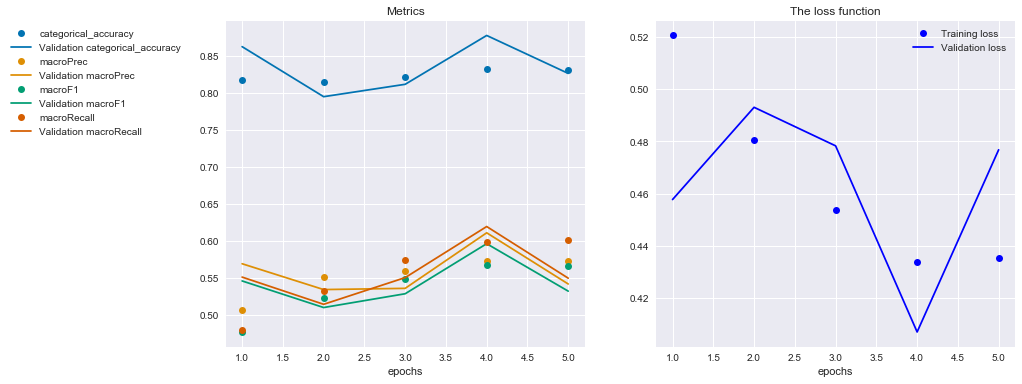

In [27]:
model_rnn2.plot(with_loss=True)

In [29]:
eval_rnn2 = model_rnn2.evaluate(X_val, y_val)

In [31]:
# 1 + 2

eval_rnn12 = pd.concat([eval_rnn1, eval_rnn2], axis=1)
eval_rnn12.columns = ['loss: cat. crossent.', 'loss: my_loss']
eval_rnn12

,loss: cat. crossent.,loss: my_loss
cat_cross,0.418292,1.060286
my_loss,0.534548,0.445170
cat_acc,0.861245,0.826225
macroPrec,0.714560,0.566758
macroF1,0.464040,0.572104
macroRecall,0.437254,0.579033


---
# LSTM

In [32]:
layers_lstm = [LSTM(24, dropout=0.1, recurrent_dropout=0.1)]

#### loss = categorical_crossentropy

In [33]:
# 1

loss='categorical_crossentropy'

model_lstm1 = BlackBox(tag="LSTM",\
                       layers=layers_rnn, loss=loss, batch_size=batch_size, optimizer=optimizer,\
                       epochs=epochs, metrics=my_metrics)

model_lstm1.load_embedd(embedd_file_crossent)
model_lstm1.summary()

loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24)                1800      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 150       
Total params: 13,867,150
Trainable params: 1,950
Non-trainable params: 13,865,200
_________________________________________________________________


In [0]:
model_lstm1.fit(X_train, y_train, validate_on=(X_val, y_val))
model_lstm1.Ksave()
model_lstm1.save_hist()

loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: False
Train on 500000 samples, validate on 200000 samples
Epoch 1/5
500000/500000 [==============================] - 2697s 5ms/step - loss: 0.6657 - categorical_accuracy: 0.7763 - macroPrec: 0.3740 - macroF1: 0.3135 - macroRecall: 0.2906 - val_loss: 0.5580 - val_categorical_accuracy: 0.8216 - val_macroPrec: 0.3909 - val_macroF1: 0.3705 - val_macroRecall: 0.3599
Epoch 2/5
500000/500000 [==============================] - 2521s 5ms/step - loss: 0.5635 - categorical_accuracy: 0.8234 - macroPrec: 0.3969 - macroF1: 0.3740 - macroRecall: 0.3615 - val_loss: 0.5108 - val_categorical_accuracy: 0.8528 - val_macroPrec: 0.4122 - val_macroF1: 0.4011 - val_macroRecall: 0.3947
Epoch 3/5
500000/500000 [==============================] - 2470s 5ms/step - loss: 0.5574 - categorical_accuracy: 0.8133 - macroPrec: 0.3900 - macroF1: 0.3674 - macroRecall: 0.3534 - val_loss: 0.6156 - val_categorical_a

In [34]:
model_lstm1.Kload()
model_lstm1.load_hist()

Ovewriting the model.


loss=categorical_crossentropy, batch_size=200, optimizer=nadam, explicit-class-weights: True, embedd-trainable: False


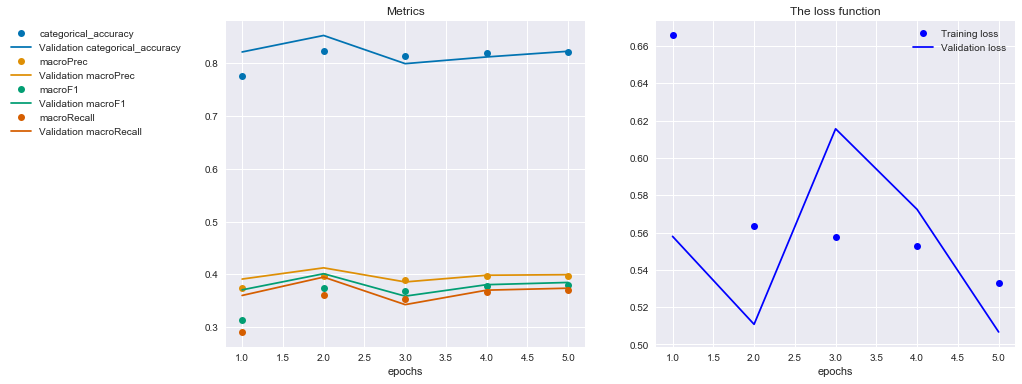

In [35]:
model_lstm1.plot(with_loss=True)

In [36]:
eval_lstm1 = model_lstm1.evaluate(X_val, y_val)

In [37]:
eval_lstm1

,LSTM
cat_cross,0.506710
my_loss,0.602793
cat_acc,0.822845
macroPrec,0.500520
macroF1,0.387134
macroRecall,0.374117


In [38]:
# 2

loss=my_loss

model_lstm2 = BlackBox(tag="LSTM",\
                       layers=layers_lstm, loss=loss, batch_size=batch_size, optimizer=optimizer,\
                       epochs=epochs, metrics=my_metrics)

model_lstm2.load_embedd(embedd_file_myloss)
model_lstm2.summary()

loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                7200      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 150       
Total params: 13,872,550
Trainable params: 7,350
Non-trainable params: 13,865,200
_________________________________________________________________


In [15]:
model_lstm2.fit(X_train, y_train, validate_on=(X_val, y_val))
model_lstm2.Ksave()
model_lstm2.save_hist()

loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: False
Train on 500000 samples, validate on 200000 samples
Epoch 1/5
500000/500000 [==============================] - 6601s 13ms/step - loss: 0.3701 - categorical_accuracy: 0.8781 - macroPrec: 0.6371 - macroF1: 0.6252 - macroRecall: 0.6605 - val_loss: 0.3196 - val_categorical_accuracy: 0.9117 - val_macroPrec: 0.6880 - val_macroF1: 0.6820 - val_macroRecall: 0.7081
Epoch 2/5
500000/500000 [==============================] - 7612s 15ms/step - loss: 0.3416 - categorical_accuracy: 0.8901 - macroPrec: 0.6831 - macroF1: 0.6594 - macroRecall: 0.6869 - val_loss: 0.4212 - val_categorical_accuracy: 0.8306 - val_macroPrec: 0.6161 - val_macroF1: 0.5752 - val_macroRecall: 0.5905
Epoch 3/5
500000/500000 [==============================] - 6646s 13ms/step - loss: 0.3083 - categorical_accuracy: 0.8841 - macroPrec: 0.7023 - macroF1: 0.6919 - macroRecall: 0.7191 - val_loss: 0.3265 - val_categorical_accuracy: 0.89

In [39]:
model_lstm2.Kload()
model_lstm2.load_hist()

Ovewriting the model.


loss=my_loss, batch_size=200, optimizer=nadam, explicit-class-weights: False, embedd-trainable: False


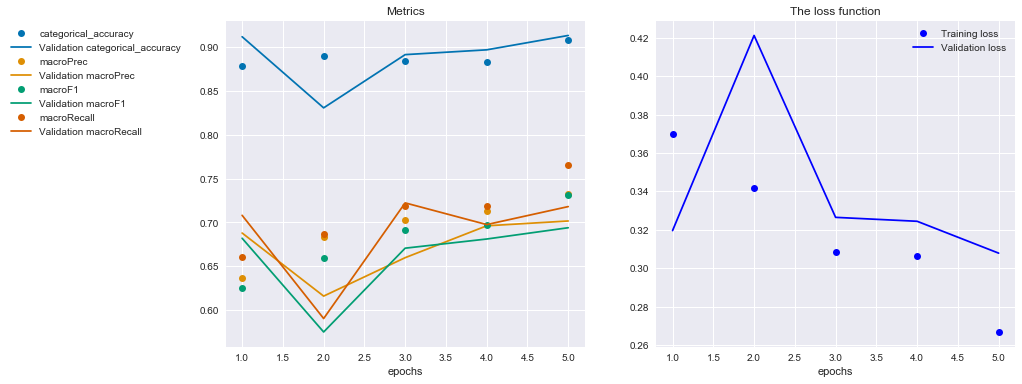

In [43]:
model_lstm2.plot(with_loss=True)

In [40]:
eval_lstm2 = model_lstm2.evaluate(X_val, y_val)

In [42]:
eval_lstm12 = pd.concat([eval_lstm1, eval_lstm2], axis=1)
eval_lstm12.columns = ['loss: cat. crossent.', 'loss: my_loss']
eval_lstm12

,loss: cat. crossent.,loss: my_loss
cat_cross,0.506710,0.602842
my_loss,0.602793,0.262010
cat_acc,0.822845,0.913115
macroPrec,0.500520,0.729040
macroF1,0.387134,0.745540
macroRecall,0.374117,0.767733


---
# Gather the four results

In [44]:
# 1 + 2

eval_together = pd.concat([eval_rnn1, eval_rnn2, eval_lstm1, eval_lstm2], axis=1)
eval_together.columns = ['SRNN_crossent', 'SRNN_myloss', 'LSTM_crossent', 'LSTM_myloss']
eval_together.T

,cat_cross,my_loss,cat_acc,macroPrec,macroF1,macroRecall
SRNN_crossent,0.418292,0.534548,0.861245,0.714560,0.464040,0.437254
SRNN_myloss,1.060286,0.445170,0.826225,0.566758,0.572104,0.579033
LSTM_crossent,0.506710,0.602793,0.822845,0.500520,0.387134,0.374117
LSTM_myloss,0.602842,0.262010,0.913115,0.729040,0.745540,0.767733


### Commentary

Metrics obtained by the examined neural networks were stable during the fitting and abysmally small when compared with the baseline of 80% macro-F1. The drop in performance is mitigated by using the custom loss function - particularly for the LSTM - but that of course is hardly useful in the end.

---
### End